# <a id='toc1_'></a>[Efficiency Analysis](#toc0_)


This notebook demonstrates the use of `EfficiencyAnalysis` class in `src/analysis/efficiency_analysis.py` for analyzing the efficiency of jobs, users, and PI groups.

**Table of contents**<a id='toc0_'></a>    
- [Efficiency Analysis](#toc1_)    
  - [Setup](#toc1_1_)    
  - [Example: Analyze Workload Efficiency Across Jobs that Use some VRAM](#toc1_2_)    
    - [Job Efficiency Metrics](#toc1_2_1_)    
      - [Find most inefficient jobs with no VRAM constraints based on `alloc_vram_efficiency`](#toc1_2_1_1_)    
    - [User Efficiency Metrics](#toc1_2_2_)    
      - [Find Inefficient Users based on `expected_value_alloc_vram_efficiency`](#toc1_2_2_1_)    
      - [Distribution of `expected_value_requested_vram_efficiency`](#toc1_2_2_2_)    
      - [Find Users with Highest `vram_hours`](#toc1_2_2_3_)    
    - [PI Group Efficiency Metrics](#toc1_2_3_)    
      - [Find PIs with Highest `vram_hours`](#toc1_2_3_1_)    
  - [Example: Analyze all jobs with no VRAM constraints](#toc1_3_)    
    - [Job Efficiency Metrics](#toc1_3_1_)    
    - [Top users with most number of jobs that have no VRAM constraints](#toc1_3_2_)    
    - [Find inefficient jobs with no VRAM Constraints based on `alloc_vram_efficiency_score`](#toc1_3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Setup](#toc0_)

In [ ]:
# Import required modules
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Jupyter server should be run at the notebook directory, so the output of the following cell would be the project root:

In [ ]:
project_root = Path.cwd().resolve().parent.parent
print(f"Project root: {project_root.name}")

Project root: ds4cg-job-analytics


In [ ]:
# Automatically reload modules before executing code (set this up BEFORE imports)
%load_ext autoreload
%autoreload 2

# Add project root to sys.path for module imports
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.analysis import efficiency_analysis as ea
from src.utilities import load_and_preprocess_jobs
from src.visualization import (
    JobsWithMetricsVisualizer,
    UsersWithMetricsVisualizer,
    PIGroupsWithMetricsVisualizer,
)
from src.config.enum_constants import MetricsDataFrameNameEnum
from src.config.paths import (
    DATA_DIR,
    JOBS_VISUALIZATION_DATA_DIR,
    USERS_VISUALIZATION_DATA_DIR,
    PI_GROUPS_VISUALIZATION_DATA_DIR,
)

In [ ]:
# Load the jobs DataFrame from DuckDB
preprocessed_jobs_df = load_and_preprocess_jobs(
    db_path=Path(DATA_DIR) / "slurm_data.db",
    table_name="Jobs",
    anonymize=True
)
display(preprocessed_jobs_df.head(10))
print(preprocessed_jobs_df.shape)

Connected to slurm_data.db
[Preprocessing] Running with new database format: GPU types as dictionary.


  processed_data = Preprocess().preprocess_data(jobs_df, apply_filter=False, anonymize=anonymize)


Found 42 records with errors. Reporting them to a summary file preprocessing_errors.log.
Processing error log file already exists. Overwriting preprocessing_errors.log
Disconnected from slurm_data.db


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram
482648,41012953,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,176635904.0,99.950012,0 days 00:35:47,11,<NA>,11,11
482647,41012951,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,172380160.0,99.964767,0 days 00:36:02,11,<NA>,11,11
482646,41012949,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171646976.0,99.970505,0 days 00:37:20,11,<NA>,11,11
482645,41012881,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171102208.0,99.945618,0 days 00:36:56,11,<NA>,11,11
482644,41012877,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171216896.0,99.963730,0 days 00:36:48,11,<NA>,11,11
482643,41012873,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,184594432.0,99.952988,0 days 00:33:03,11,<NA>,11,11
482642,41012869,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,160063488.0,99.963593,0 days 00:34:07,11,<NA>,11,11
482641,41012867,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,171073536.0,99.922615,0 days 00:32:46,11,<NA>,11,11
482640,41012866,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,172363776.0,99.959511,0 days 00:32:19,11,<NA>,11,11
482639,41012864,<NA>,-1,job.sh,False,non-interactive,account_98,user_732,['2080ti'],normal,...,{'2080_ti': 1},0.0,0.0,173252608.0,99.921066,0 days 00:33:00,11,<NA>,11,11


(660508, 31)


## <a id='toc1_2_'></a>[Example: Analyze Workload Efficiency Across Jobs that Use some VRAM](#toc0_)


In [ ]:
efficiency_analysis = ea.EfficiencyAnalysis(
    jobs_df=preprocessed_jobs_df, metrics_df_name_enum=MetricsDataFrameNameEnum
)

In [ ]:
filtered_jobs = efficiency_analysis.filter_jobs_for_analysis(
    gpu_mem_usage_filter={"min": 0, "inclusive": False}, elapsed_seconds_min=600
)
filtered_jobs

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram
482636,41012771,41012768,0,sbatch,True,non-interactive,account_279,user_973,"['sm_70', 'sm_80', 'sm_86', 'sm_89', 'sm_90']",normal,...,{'2080_ti': 1},4.404019e+08,92.0,1.075294e+09,12.541477,0 days 00:00:23,<NA>,<NA>,<NA>,11
482627,41000802,41000615,22,census_paper_kappa_beta,True,non-interactive,account_219,user_57,[],normal,...,{'a16': 1},1.048576e+08,88.0,1.533571e+09,39.299606,0 days 00:02:28,<NA>,<NA>,<NA>,16
482623,41000797,41000615,21,census_paper_kappa_beta,True,non-interactive,account_219,user_57,[],normal,...,{'a16': 1},1.048576e+08,87.0,1.508696e+09,40.032154,0 days 00:02:08,<NA>,<NA>,<NA>,16
482591,41000775,41000615,18,census_paper_kappa_beta,True,non-interactive,account_219,user_57,[],normal,...,{'a16': 1},1.048576e+08,83.0,1.275314e+09,38.211792,0 days 00:02:28,<NA>,<NA>,<NA>,16
482583,41012510,41012509,0,sbatch,True,non-interactive,account_279,user_973,"['sm_70', 'sm_80', 'sm_86', 'sm_89', 'sm_90']",normal,...,{'2080_ti': 1},4.424991e+08,93.0,1.112781e+09,12.569467,0 days 00:00:04,<NA>,<NA>,<NA>,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273712,23988975,<NA>,-1,simQuad.sh,False,non-interactive,account_63,user_604,['gpu:a100'],normal,...,{'a100': 1},1.388105e+10,98.0,5.944361e+08,19.790009,0 days 00:00:02,80,80,80,80
267091,23946071,<NA>,-1,sbatch,False,non-interactive,account_21,user_901,['vram40'],normal,...,{'rtx_8000': 1},1.913022e+10,82.0,1.739481e+10,49.981564,0 days 00:02:10,40,<NA>,40,48
267278,23946070,<NA>,-1,sbatch,False,non-interactive,account_21,user_901,['vram40'],normal,...,{'rtx_8000': 1},1.913022e+10,82.0,1.402193e+10,49.977093,0 days 00:00:07,40,<NA>,40,48
267277,23946069,<NA>,-1,sbatch,False,non-interactive,account_21,user_901,['vram40'],normal,...,{'rtx_8000': 1},1.915119e+10,81.0,1.742611e+10,49.961525,0 days 00:00:10,40,<NA>,40,48


Generate all metrics:

In [ ]:
metrics_dict = efficiency_analysis.calculate_all_efficiency_metrics(filtered_jobs)

jobs_with_metrics = metrics_dict["jobs_with_efficiency_metrics"]
users_with_metrics = metrics_dict["users_with_efficiency_metrics"]
pi_accounts_with_metrics = metrics_dict["pi_accounts_with_efficiency_metrics"]

### <a id='toc1_2_1_'></a>[Job Efficiency Metrics](#toc0_)

In [ ]:
# Set option to display all columns
pd.set_option("display.max_columns", None)
# Display the DataFrame
display(jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option("display.max_columns")

print(f"Jobs found: {len(jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,requested_vram_efficiency,alloc_vram_efficiency_score,requested_vram_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency,cpu_core_count
482636,41012771,41012768,0,sbatch,True,non-interactive,account_279,user_973,"['sm_70', 'sm_80', 'sm_86', 'sm_89', 'sm_90']",normal,COMPLETED,SUCCESS,2025-08-13 06:45:10,2025-08-13 06:45:33,0 days 00:29:39,2 days 00:00:00,gpu,[gypsum-gpu162],1,{'2080_ti': 1},4.404019e+08,92.0,12.541477,0 days 00:00:23,<NA>,<NA>,<NA>,11,0.494167,5.435833,0.410156,0.037287,<NA>,-17.879067,<NA>,1.001446,128.0,0.007824,8
482627,41000802,41000615,22,census_paper_kappa_beta,True,non-interactive,account_219,user_57,[],normal,COMPLETED,SUCCESS,2025-08-13 06:32:58,2025-08-13 06:35:26,0 days 00:51:36,0 days 10:00:00,gpu-preempt,[gpu049],1,{'a16': 1},1.048576e+08,88.0,39.299606,0 days 00:02:28,<NA>,<NA>,<NA>,16,0.86,13.76,0.097656,0.006104,<NA>,-70.160731,<NA>,1.428249,200.0,0.007141,20
482623,41000797,41000615,21,census_paper_kappa_beta,True,non-interactive,account_219,user_57,[],normal,COMPLETED,SUCCESS,2025-08-13 06:18:04,2025-08-13 06:20:12,0 days 00:52:49,0 days 10:00:00,gpu-preempt,[gpu048],1,{'a16': 1},1.048576e+08,87.0,40.032154,0 days 00:02:08,<NA>,<NA>,<NA>,16,0.880278,14.084444,0.097656,0.006104,<NA>,-71.815038,<NA>,1.405083,200.0,0.007025,20
482591,41000775,41000615,18,census_paper_kappa_beta,True,non-interactive,account_219,user_57,[],normal,COMPLETED,SUCCESS,2025-08-13 05:55:57,2025-08-13 05:58:25,0 days 00:51:57,0 days 10:00:00,gpu-preempt,[gpu048],1,{'a16': 1},1.048576e+08,83.0,38.211792,0 days 00:02:28,<NA>,<NA>,<NA>,16,0.865833,13.853333,0.097656,0.006104,<NA>,-70.636628,<NA>,1.187729,200.0,0.005939,20
482583,41012510,41012509,0,sbatch,True,non-interactive,account_279,user_973,"['sm_70', 'sm_80', 'sm_86', 'sm_89', 'sm_90']",normal,COMPLETED,SUCCESS,2025-08-13 05:54:18,2025-08-13 05:54:22,0 days 00:43:20,2 days 00:00:00,gpu,[gypsum-gpu191],1,{'2080_ti': 1},4.424991e+08,93.0,12.569467,0 days 00:00:04,<NA>,<NA>,<NA>,11,0.722222,7.944444,0.412109,0.037464,<NA>,-26.09243,<NA>,1.036358,128.0,0.008097,8
482566,41012486,<NA>,-1,interactive,False,shell,account_177,user_211,"['sm_80', 'vram80']",short,COMPLETED,SUCCESS,2025-08-13 05:48:44,2025-08-13 05:48:45,0 days 00:31:51,0 days 01:00:00,gpu,[uri-gpu009],1,{'h100': 1},2.090231e+10,95.0,3.847968,0 days 00:00:01,80,<NA>,80,80,0.530833,42.466667,19.466797,0.243335,0.243335,-60.018834,-60.018834,23.698650,40.0,0.592466,12
482546,41012428,41012426,0,sbatch,True,non-interactive,account_279,user_973,"['sm_70', 'sm_80', 'sm_86', 'sm_89', 'sm_90']",normal,COMPLETED,SUCCESS,2025-08-13 05:40:49,2025-08-13 05:41:09,0 days 00:13:15,2 days 00:00:00,gpu,[gypsum-gpu164],1,{'2080_ti': 1},4.362076e+08,93.0,12.677705,0 days 00:00:20,<NA>,<NA>,<NA>,11,0.220833,2.429167,0.406250,0.036932,<NA>,-8.013048,<NA>,1.000870,128.0,0.007819,8
482537,41012392,41012391,0,sbatch,True,non-interactive,account_279,user_973,"['sm_70', 'sm_80', 'sm_86', 'sm_89', 'sm_90']",normal,COMPLETED,SUCCESS,2025-08-13 05:36:29,2025-08-13 05:36:35,0 days 00:45:49,2 days 00:00:00,gpu,[gypsum-gpu162],1,{'2080_ti': 1},4.424991e+08,92.0,12.519644,0 days 00:00:06,<NA>,<NA>,<NA>,11,0.763611,8.399722,0.412109,0.037464,<NA>,-27.587726,<NA>,1.026287,128.0,0.008018,8
482502,41011721,<NA>,-1,train_eval_gsm8k_Llama70b_assess-128_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu025],1,{'l40s': 1},4.512652e+10,91.0,21.434895,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,42.027344,0.875570,0.87557,-19.157834,-19.157834,29.969784,30.0,0.998993

Jobs found: 463863


#### <a id='toc1_2_1_1_'></a>[Find most inefficient jobs with no VRAM constraints based on `alloc_vram_efficiency`](#toc0_)


Top inefficient Jobs by Allocated VRAM Efficiency:


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,vram_hours,used_vram_gib,alloc_vram_efficiency,requested_vram_efficiency,alloc_vram_efficiency_score,requested_vram_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency,cpu_core_count
162608,38558388,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,account_07,user_313,['vram48'],normal,...,384.373333,0.001469,0.000031,0.000031,-3995.409713,-3995.409713,8.984646,32.0,0.280770,3
227627,38865983,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,account_07,user_313,['vram48'],normal,...,384.066667,0.002987,0.000062,0.000062,-3719.577193,-3719.577193,8.931816,32.0,0.279119,3
227182,38867161,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,account_07,user_313,['vram48'],normal,...,384.293333,0.002987,0.000062,0.000062,-3721.772395,-3721.772395,8.887802,32.0,0.277744,3
228322,38904435,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,account_07,user_313,['vram48'],normal,...,384.093333,0.002987,0.000062,0.000062,-3719.835452,-3719.835452,8.946518,32.0,0.279579,3
125268,38301425,<NA>,-1,sys/dashboard/sys/bc_jupyter,False,bc_jupyter,account_07,user_313,['vram48'],normal,...,384.08,0.002987,0.000062,0.000062,-3719.706322,-3719.706322,8.917610,32.0,0.278675,3
512530,30811020,<NA>,-1,interactive,False,shell,account_106,user_755,['gpu:m40'],normal,...,23.108611,0.001579,0.000069,0.000069,-221.525559,-221.525559,3.906849,64.0,0.061045,6
512583,30814523,<NA>,-1,interactive,False,shell,account_106,user_755,['gpu:m40'],normal,...,23.108611,0.001579,0.000069,0.000069,-221.525559,-221.525559,3.882717,64.0,0.060667,6
651305,26339347,<NA>,-1,bash,False,shell,account_50,user_416,['a100'],normal,...,179.822222,0.013672,0.000085,0.000085,-1684.500543,-1684.500543,1.298977,200.0,0.006495,32
375003,28602240,<NA>,-1,sys/dashboard/sys/bc_desktop,False,bc_desktop,account_155,user_46,['x86_64'],normal,...,92.044722,0.002556,0.000111,<NA>,-838.054839,<NA>,5.990971,32.0,0.187218,4
464569,25831431,<NA>,-1,sys/dashboard/sys/bc_desktop,False,bc_desktop,account_117,user_935,"['x86_64', 'gpu:l40s']",normal,...,1785.0,0.006733,0.000140,0.00014,-15836.420561,-15836.420561,63.949837,64.0,0.999216,8


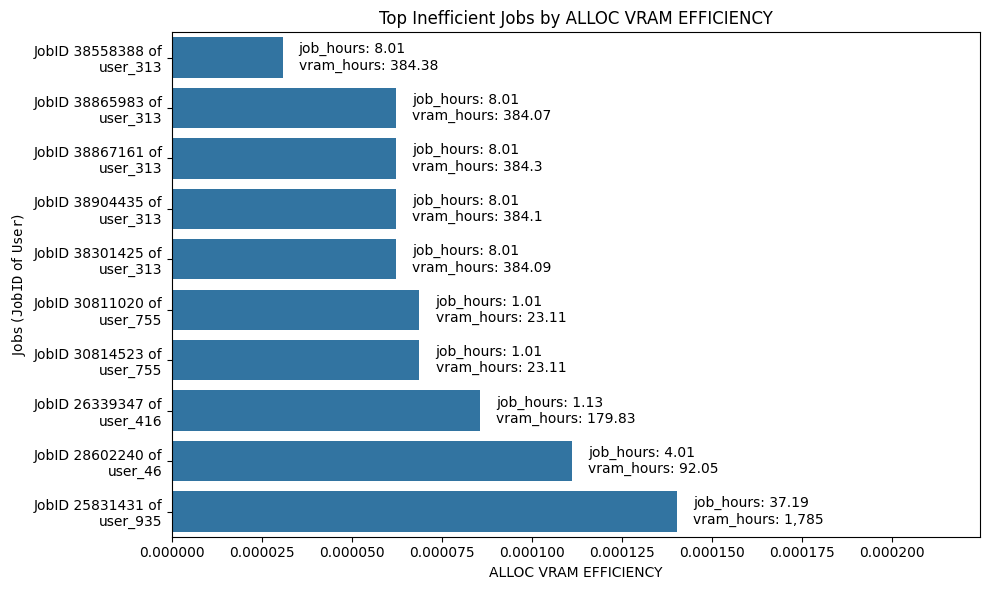

In [ ]:
inefficient_jobs_alloc_vram_eff = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=MetricsDataFrameNameEnum.JOBS,
    sorting_key="alloc_vram_efficiency",
    ascending=True,  # Sort by alloc_vram_efficiency in ascending order
    filter_criteria={
        # "alloc_vram_efficiency": {"min": 80 * 24, "inclusive": True},
    },
)
# Display top inefficient users by allocated VRAM efficiency
print("\nTop inefficient Jobs by Allocated VRAM Efficiency:")
display(inefficient_jobs_alloc_vram_eff.head(10))

# Plot top inefficient jobs by allocated VRAM efficiency, with efficiency as labels
jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(inefficient_jobs_alloc_vram_eff.head(10))
jobs_with_metrics_visualizer.visualize(
    output_dir_path=JOBS_VISUALIZATION_DATA_DIR,
    column="alloc_vram_efficiency",
    bar_label_columns=["job_hours", "vram_hours"],
    figsize=(10, 6),
)

### <a id='toc1_2_2_'></a>[User Efficiency Metrics](#toc0_)

In [ ]:
users_with_metrics

,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count,vram_hours
0,user_01,312,2013.829722,account_288,-376.436134,-442.50696,0.435577,0.373203,1.316907,93344.522222
1,user_02,70,1561.586389,account_252,-1725.032831,-1674.612962,0.387995,0.395304,1.412745,83753.096944
2,user_03,231,3411.456667,account_05,-6803.585527,-6835.966556,0.213308,0.213091,3.604497,749234.942778
3,user_04,316,553.818889,account_125,-36.18073,-36.268811,0.779349,0.779009,1.014414,44560.546667
4,user_05,262,2910.031944,account_111,-994.735622,-984.302998,0.486316,0.490494,1.617360,249461.198333
...,...,...,...,...,...,...,...,...,...,...
776,user_991,14058,15732.148889,account_272,-36.057322,-13.756767,0.197313,0.057329,1.000000,217972.611944
777,user_992,11,117.076944,account_245,-434.342233,<NA>,0.24206,<NA>,1.863806,2548.665556
778,user_995,3,7.253056,account_111,-240.610427,-320.249221,0.179515,0.116689,1.000000,378.982222
779,user_996,6,3.301111,account_27,-126.160798,-117.050865,0.009706,0.013095,1.000000,161.798333


#### <a id='toc1_2_2_1_'></a>[Find Inefficient Users based on `expected_value_alloc_vram_efficiency`](#toc0_)


Top inefficient users by allocated vram efficiency:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count,vram_hours
377,user_530,35,944.06,account_304,-55192.298478,-59678.610741,0.001673,0.001525,4.000000,3.020992e+05
107,user_196,15,218.518611,account_179,-30454.599654,<NA>,0.003467,<NA>,7.077803,6.487870e+04
442,user_605,263,14784.038056,account_17,-22459.685004,-6237.596447,0.004466,0.000842,6.711243,1.035941e+06
645,user_843,5,10.715833,account_266,-3300.821225,-3380.345196,0.005543,0.004696,5.157288,3.105187e+03
86,user_172,59,1954.228056,account_297,-50892.684746,-51123.456961,0.005687,0.005494,3.999054,5.760878e+05
367,user_518,19,48.045833,account_61,-1030.167376,-1030.167376,0.006144,0.006144,1.000000,3.843667e+03
448,user_613,5,4.331667,account_133,-148.482691,-143.942155,0.006724,0.007615,1.000000,1.436325e+02
617,user_810,14,86.796667,account_261,-4505.252536,-6940.392763,0.006817,0.006144,3.760005,1.237934e+04
166,user_267,5,8.562222,account_02,-396.930467,-365.620992,0.0077,0.011333,1.000000,4.026889e+02
75,user_156,8,10.616111,account_43,-96.759961,<NA>,0.008421,<NA>,1.000000,1.610253e+02


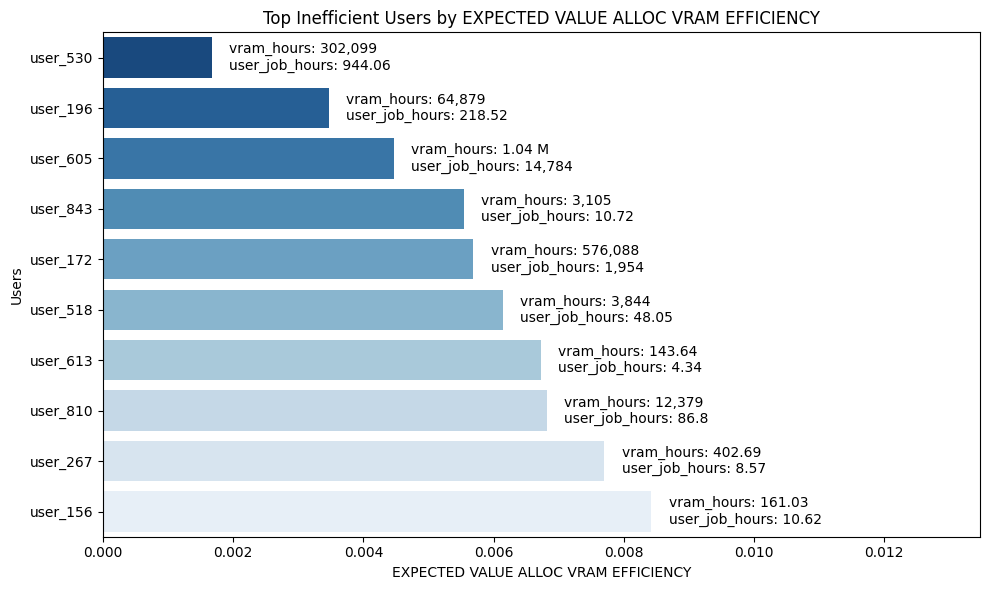

In [ ]:
inefficient_users_alloc_vram_eff = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=MetricsDataFrameNameEnum.USERS,
    sorting_key="expected_value_alloc_vram_efficiency",
    ascending=True,  # we want to find users with low efficiency
    filter_criteria={
        "expected_value_alloc_vram_efficiency": {"max": 0.3, "inclusive": True},
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a user
    },
)
print("\nTop inefficient users by allocated vram efficiency:")
display(inefficient_users_alloc_vram_eff.head(20))

# Plot top inefficient users by allocated vram efficiency, with allocated vram efficiency as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(inefficient_users_alloc_vram_eff.head(10))
users_with_metrics_visualizer.visualize(
    column="expected_value_alloc_vram_efficiency",
    bar_label_columns=["vram_hours", "user_job_hours"],
    figsize=(10, 6),
)

#### <a id='toc1_2_2_2_'></a>[Distribution of `expected_value_requested_vram_efficiency`](#toc0_)

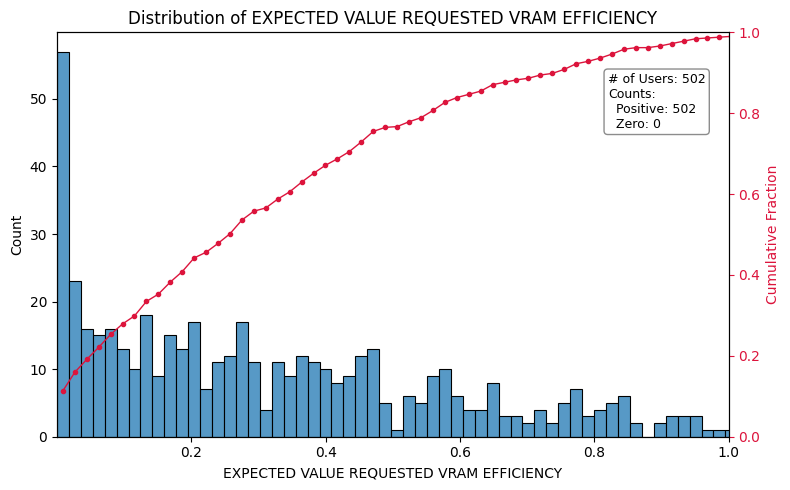

In [ ]:
inefficient_users_ev_req_vram_eff = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=MetricsDataFrameNameEnum.USERS,
    sorting_key="expected_value_requested_vram_efficiency",
    ascending=True,  # Sort by expected_value_requested_vram_efficiency in ascending order
    filter_criteria={
        "job_count": {"min": 5, "inclusive": True},  # minimum job count threshold
    },
)
users_with_metrics_ev_visualizer = UsersWithMetricsVisualizer(inefficient_users_ev_req_vram_eff)
users_with_metrics_ev_visualizer.visualize_metric_distribution(
    output_dir_path=USERS_VISUALIZATION_DATA_DIR, column="expected_value_requested_vram_efficiency", figsize=(8, 5)
)

#### <a id='toc1_2_2_3_'></a>[Find Users with Highest `vram_hours`](#toc0_)


Top users by VRAM-hours:


,User,job_count,user_job_hours,pi_account,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count,vram_hours
15,user_1005,697,105835.925,account_304,<NA>,-252348.011786,<NA>,0.001333,4.976322,3.359777e+07
401,user_558,317,22338.849167,account_103,-262449.296581,-264001.879625,0.022836,0.022983,40.178159,1.833773e+07
556,user_732,65589,152266.486944,account_98,-493.859603,-515.585349,0.008604,0.006383,1.000000,6.615882e+06
755,user_97,317,14992.952222,account_205,-47282.412613,-47882.595277,0.141635,0.14163,7.662242,6.481426e+06
183,user_288,2313,105744.081111,account_94,-7949.804762,-3131.554773,0.063253,0.019467,4.992145,6.091622e+06
193,user_30,583,67891.600833,account_17,-52543.681108,-70376.420347,0.009114,0.002519,5.250636,5.549345e+06
219,user_331,328,15125.453056,account_116,<NA>,-25000.095453,<NA>,0.166837,4.946278,4.946089e+06
749,user_964,828,14059.644722,account_262,-9001.544762,-9186.43509,0.212172,0.212149,4.354937,4.398083e+06
19,user_101,2171,16493.559722,account_116,-3830.378555,-3823.751003,0.283703,0.287536,5.845885,3.920441e+06
327,user_466,14,7085.508889,account_108,-1083110.355128,-1083110.355128,0.016187,0.016187,8.194264,3.505422e+06


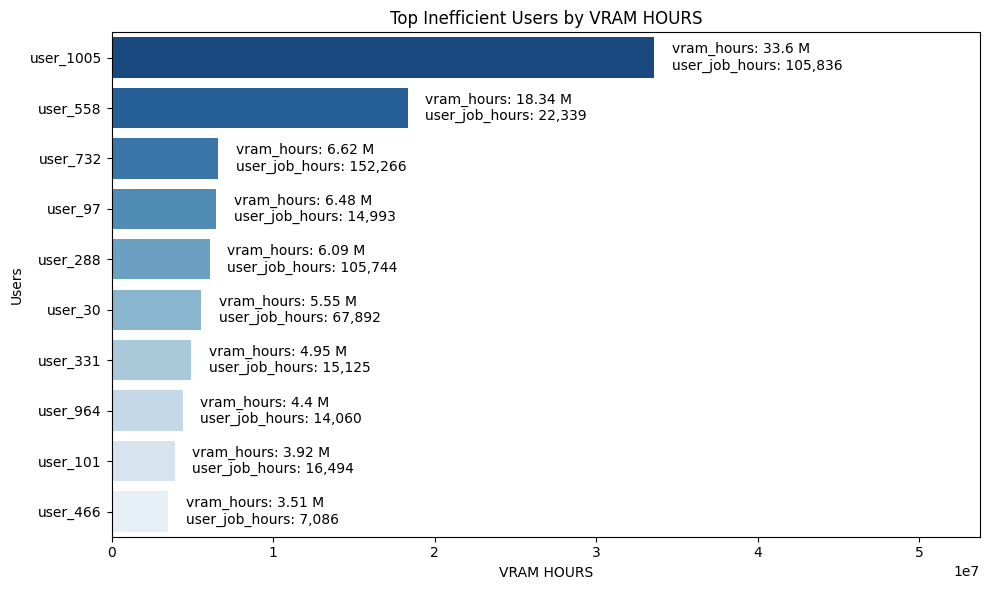

In [ ]:
users_with_highest_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=MetricsDataFrameNameEnum.USERS,
    sorting_key="vram_hours",
    ascending=False,  # Sort by vram_hours in descending order
)
# Display top users by VRAM-hours
print("\nTop users by VRAM-hours:")
display(users_with_highest_vram_hours.head(20))


# Plot top users by VRAM-hours, with VRAM-hours as labels
users_with_metrics_visualizer = UsersWithMetricsVisualizer(users_with_highest_vram_hours.head(10))
users_with_metrics_visualizer.visualize(
    column="vram_hours", bar_label_columns=["vram_hours", "user_job_hours"], figsize=(10, 6)
)

### <a id='toc1_2_3_'></a>[PI Group Efficiency Metrics](#toc0_)

In [ ]:
pi_accounts_with_metrics

,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count
0,account_101,11316,76485.67,5,4.676935e+06,-793.054498,-1106.770109,0.396305,0.383152,1.668918
1,account_36,2774,25349.388056,9,1.492300e+06,-349.595223,-611.819708,0.256006,0.249356,3.501491
2,account_238,37,529.387222,2,2.938982e+04,-3304.07409,<NA>,0.053941,<NA>,4.021917
3,account_303,20,100.200278,2,5.590667e+03,-2631.77737,-758.026297,0.084939,0.075065,2.906421
4,account_246,62,613.028889,1,3.393105e+04,-2094.999836,-2143.993324,0.058255,0.052113,1.475564
...,...,...,...,...,...,...,...,...,...,...
231,account_14,1096,8144.030278,7,1.447648e+06,-9397.564303,-9400.080703,0.127788,0.125943,3.282858
232,account_72,3,1.029444,1,2.367722e+01,-17.827113,<NA>,0.143856,<NA>,1.000000
233,account_274,2,6.008056,1,1.401914e+02,-194.653964,-320.633675,0.090539,0.024415,1.000000
234,account_120,239,1027.653611,4,6.478232e+04,-1260.808055,-1028.495733,0.261716,0.231884,2.710185


#### <a id='toc1_2_3_1_'></a>[Find PIs with Highest `vram_hours`](#toc0_)


Top inefficient PI Groups by VRAM-hours:


,pi_account,job_count,pi_acc_job_hours,user_count,pi_acc_vram_hours,avg_alloc_vram_efficiency_score,avg_requested_vram_efficiency_score,expected_value_alloc_vram_efficiency,expected_value_requested_vram_efficiency,expected_value_gpu_count
32,account_304,1039,113545.038333,3,3.413163e+07,-29404.285819,-106864.758351,0.000079,0.001361,4.940680
131,account_103,1367,26715.891944,2,1.862981e+07,-131355.383761,-132199.437447,0.029722,0.029498,39.563923
127,account_116,5095,75156.922778,18,1.407608e+07,-2805.9248,-4914.364457,0.189903,0.247023,4.399423
23,account_187,10016,37249.653056,11,8.677847e+06,-2575.51016,-2548.846031,0.227040,0.225512,5.277519
54,account_205,662,18418.27,4,7.266607e+06,-16597.454176,-19866.672425,0.127055,0.137541,7.525455
158,account_17,923,85200.952778,3,7.070270e+06,-37096.104471,-47391.058746,0.008670,0.002692,5.358943
139,account_98,65589,152266.486944,1,6.615882e+06,-493.859603,-515.585349,0.008604,0.006383,1.000000
199,account_94,7068,132313.496389,7,6.420683e+06,-2433.145357,-4612.798457,0.064639,0.023077,4.787546
64,account_262,10072,36170.311111,4,5.090398e+06,-2381.178527,-2887.526736,0.212102,0.206221,3.903893
0,account_101,11316,76485.67,5,4.676935e+06,-793.054498,-1106.770109,0.396305,0.383152,1.668918


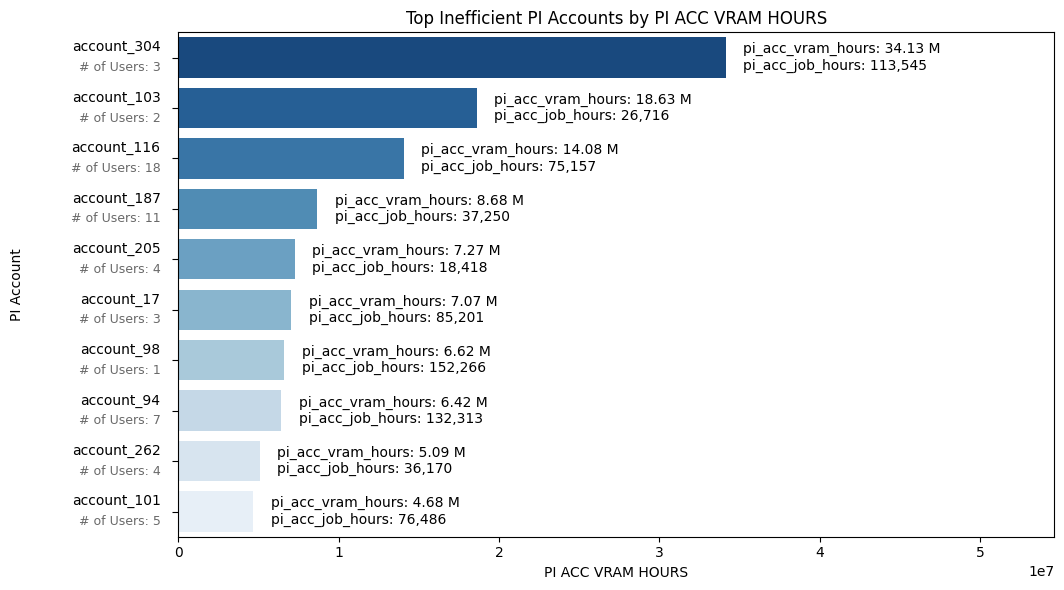

In [ ]:
top_pi_groups_by_vram_hours = efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=MetricsDataFrameNameEnum.PI_GROUPS,
    sorting_key="pi_acc_vram_hours",
    ascending=False,
    filter_criteria={
        "pi_acc_vram_hours": {"min": 200, "inclusive": True},  # VRAM-hours threshold for identifying inefficient users
        "job_count": {"min": 5, "inclusive": True},  # Minimum number of jobs to consider a PI account
    },
)
# Display top inefficient users by VRAM-hours
print("\nTop inefficient PI Groups by VRAM-hours:")
display(top_pi_groups_by_vram_hours.head(20))

pi_group_visualizer = PIGroupsWithMetricsVisualizer(top_pi_groups_by_vram_hours.head(10))
pi_group_visualizer.visualize(
    output_dir_path=PI_GROUPS_VISUALIZATION_DATA_DIR,
    column="pi_acc_vram_hours",
    bar_label_columns=["pi_acc_vram_hours", "pi_acc_job_hours"],
    figsize=(10, 6),
)

## <a id='toc1_3_'></a>[Example: Analyze all jobs with no VRAM constraints](#toc0_)

In [ ]:
# Filter jobs where no VRAM constraint was set but a GPU was allocated
no_vram_constraint_efficiency_analysis = ea.EfficiencyAnalysis(
    jobs_df=preprocessed_jobs_df, metrics_df_name_enum=MetricsDataFrameNameEnum
)
all_no_vram_constraint_jobs = no_vram_constraint_efficiency_analysis.filter_jobs_for_analysis(
    vram_constraint_filter={"min": 0, "inclusive": False},  # No VRAM constraints
    gpu_count_filter={"min": 1, "inclusive": True},  # At least one GPU allocated
    gpu_mem_usage_filter={"min": 0, "inclusive": False},  # Used more than 0 GiB of VRAM
)

display(all_no_vram_constraint_jobs.head(10))
print(all_no_vram_constraint_jobs.shape)

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram
482566,41012486,<NA>,-1,interactive,False,shell,account_177,user_211,"['sm_80', 'vram80']",short,...,{'h100': 1},2.090231e+10,95.0,2.544623e+10,3.847968,0 days 00:00:01,80,<NA>,80,80
482502,41011721,<NA>,-1,train_eval_gsm8k_Llama70b_assess-128_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,...,{'l40s': 1},4.512652e+10,91.0,3.217981e+10,21.434895,0 days 00:00:18,48,<NA>,48,48
482505,41011724,<NA>,-1,train_eval_gsm8k_Llama70b_assess-512_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,...,{'l40s': 1},4.504682e+10,97.0,3.217974e+10,23.747896,0 days 00:00:18,48,<NA>,48,48
482501,41011720,<NA>,-1,train_eval_gsm8k_Llama70b_assess-128_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,...,{'l40s': 1},4.733272e+10,89.0,3.217993e+10,21.385380,0 days 00:00:18,48,<NA>,48,48
482506,41011725,<NA>,-1,train_eval_gsm8k_Llama70b_assess-512_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,...,{'l40s': 1},4.501327e+10,97.0,3.217968e+10,23.800268,0 days 00:00:18,48,<NA>,48,48
482503,41011722,<NA>,-1,train_eval_gsm8k_Llama70b_assess-256_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,...,{'l40s': 1},4.457916e+10,97.0,3.217991e+10,21.234501,0 days 00:00:18,48,<NA>,48,48
482504,41011723,<NA>,-1,train_eval_gsm8k_Llama70b_assess-256_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,...,{'l40s': 1},4.642256e+10,97.0,3.217993e+10,21.256886,0 days 00:00:18,48,<NA>,48,48
482491,41011409,<NA>,-1,llada_math500_mi,False,non-interactive,account_177,user_211,"['vram80', 'bf16']",normal,...,{'a100': 1},3.720138e+10,100.0,1.581539e+09,19.923502,0 days 00:09:07,80,80,80,80
482490,41011408,<NA>,-1,llada_math500_mi,False,non-interactive,account_177,user_211,"['vram80', 'bf16']",normal,...,{'a100': 1},3.720138e+10,100.0,1.574261e+09,19.960974,0 days 00:08:08,80,80,80,80
482489,41011407,<NA>,-1,llada_math500_mi,False,non-interactive,account_177,user_211,"['vram80', 'bf16']",normal,...,{'a100': 1},3.096235e+10,100.0,1.862136e+10,18.733139,0 days 00:00:32,80,<NA>,80,80


(314996, 31)


### <a id='toc1_3_1_'></a>[Job Efficiency Metrics](#toc0_)

In [ ]:
no_vram_constraint_jobs_with_metrics = no_vram_constraint_efficiency_analysis.calculate_job_efficiency_metrics(
    all_no_vram_constraint_jobs
)

# Set option to display all columns
pd.set_option("display.max_columns", None)
# Display the DataFrame
display(no_vram_constraint_jobs_with_metrics.head(10))
# To revert to default settings (optional)
pd.reset_option("display.max_columns")
print(f"Jobs found: {len(no_vram_constraint_jobs_with_metrics)}")

,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,Status,ExitCode,SubmitTime,StartTime,Elapsed,TimeLimit,Partition,NodeList,gpu_count,GPUType,GPUMemUsage,GPUComputeUsage,CPUComputeUsage,Queued,vram_constraint,partition_constraint,requested_vram,allocated_vram,job_hours,vram_hours,used_vram_gib,alloc_vram_efficiency,requested_vram_efficiency,alloc_vram_efficiency_score,requested_vram_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency,cpu_core_count
482566,41012486,<NA>,-1,interactive,False,shell,account_177,user_211,"['sm_80', 'vram80']",short,COMPLETED,SUCCESS,2025-08-13 05:48:44,2025-08-13 05:48:45,0 days 00:31:51,0 days 01:00:00,gpu,[uri-gpu009],1,{'h100': 1},2.090231e+10,95.0,3.847968,0 days 00:00:01,80,<NA>,80,80,0.530833,42.466667,19.466797,0.243335,0.243335,-60.018834,-60.018834,23.698650,40.0,0.592466,12
482502,41011721,<NA>,-1,train_eval_gsm8k_Llama70b_assess-128_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu025],1,{'l40s': 1},4.512652e+10,91.0,21.434895,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,42.027344,0.875570,0.87557,-19.157834,-19.157834,29.969784,30.0,0.998993,2
482505,41011724,<NA>,-1,train_eval_gsm8k_Llama70b_assess-512_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.504682e+10,97.0,23.747896,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,41.953125,0.874023,0.874023,-19.412664,-19.412664,29.969715,30.0,0.998991,2
482501,41011720,<NA>,-1,train_eval_gsm8k_Llama70b_assess-128_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu025],1,{'l40s': 1},4.733272e+10,89.0,21.385380,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,44.082031,0.918376,0.918376,-12.276181,-12.276181,29.969898,30.0,0.998997,2
482506,41011725,<NA>,-1,train_eval_gsm8k_Llama70b_assess-512_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.501327e+10,97.0,23.800268,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,41.921875,0.873372,0.873372,-19.520095,-19.520095,29.969662,30.0,0.998989,2
482503,41011722,<NA>,-1,train_eval_gsm8k_Llama70b_assess-256_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.457916e+10,97.0,21.234501,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,41.517578,0.864950,0.86495,-20.917259,-20.917259,29.969879,30.0,0.998996,2
482504,41011723,<NA>,-1,train_eval_gsm8k_Llama70b_assess-256_assess_sft,False,non-interactive,account_177,user_437,['l40s'],normal,TIMEOUT,SUCCESS,2025-08-13 05:26:38,2025-08-13 05:26:56,0 days 03:00:13,0 days 03:00:00,gpu,[gpu026],1,{'l40s': 1},4.642256e+10,97.0,21.256886,0 days 00:00:18,48,<NA>,48,48,3.003611,144.173333,43.234375,0.900716,0.900716,-15.075501,-15.075501,29.969894,30.0,0.998996,2
482491,41011409,<NA>,-1,llada_math500_mi,False,non-interactive,account_177,user_211,"['vram80', 'bf16']",normal,COMPLETED,SUCCESS,2025-08-13 05:23:21,2025-08-13 05:32:28,0 days 02:19:29,1 days 00:00:00,superpod-a100,[gpu019],1,{'a100': 1},3.720138e+10,100.0,19.923502,0 days 00:09:07,80,80,80,80,2.324722,185.977778,34.646484,0.433081,0.433081,-155.631854,-155.631854,1.472923,40.0,0.036823,5
482490,41011408,<NA>,-1,llada_math500_mi,False,non-interactive,account_177,user_211,"['vram80', 'bf16']",normal,COMPLETED,SUCCESS,2025-08-13 05:23:21,2025-08-13 05:31:29,0 days 02:55:25,1 days 00:00:00,superpod-a100,[gpu020],1,{'a100': 1},3.720138e+10,100.0,19.960974,0 days 00:08:08,80,80,80,80,2.923611,233.888889,34.646484,0.4

Jobs found: 314996


### <a id='toc1_3_2_'></a>[Top users with most number of jobs that have no VRAM constraints](#toc0_)

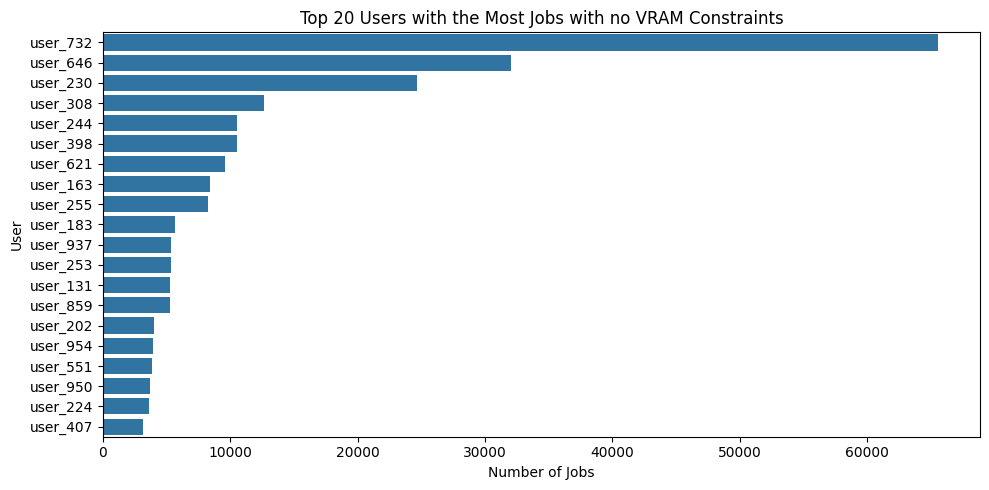

In [ ]:
# Plot top users by number of jobs with no VRAM constraints
if not all_no_vram_constraint_jobs.empty:
    plt.figure(figsize=(10, 5))
    user_counts = all_no_vram_constraint_jobs["User"].value_counts().head(20)
    sns.barplot(x=user_counts.values, y=user_counts.index, orient="h")
    plt.xlabel("Number of Jobs")
    plt.ylabel("User")
    plt.title("Top 20 Users with the Most Jobs with no VRAM Constraints")
    plt.tight_layout()
    plt.show()
else:
    print("No jobs found without VRAM constraints.")

### <a id='toc1_3_3_'></a>[Find inefficient jobs with no VRAM Constraints based on `alloc_vram_efficiency_score`](#toc0_)


Top inefficient Jobs by allocated VRAM efficiency score:


,JobID,ArrayJobID,ArrayID,JobName,IsArray,Interactive,Account,User,Constraints,QOS,...,vram_hours,used_vram_gib,alloc_vram_efficiency,requested_vram_efficiency,alloc_vram_efficiency_score,requested_vram_efficiency_score,used_cpu_mem_gib,allocated_cpu_mem_gib,cpu_mem_efficiency,cpu_core_count
565525,36489998,<NA>,-1,train-14M-aoa-dec-300B-seed1,False,non-interactive,account_103,user_558,['2080ti'],normal,...,2162950.826667,1.500000,0.002131,0.002131,-13304988.074955,-13304988.074955,3.757011,7040.0,0.000534,128
620935,37845053,<NA>,-1,train-14M-RVV-dec-300B-seed2,False,non-interactive,account_103,user_558,['2080ti'],normal,...,2162888.248889,1.500000,0.002131,0.002131,-13304603.139442,-13304603.139442,3.624798,10560.0,0.000343,128
622812,37710003,<NA>,-1,train-14M-RVV-dec-300B-seed2,False,non-interactive,account_103,user_558,['2080ti'],normal,...,2162888.248889,9.632812,0.013683,0.013683,-9282257.950467,-9282257.950467,8.661381,6336.0,0.001367,128
267151,24009623,<NA>,-1,ADISeN,False,non-interactive,account_108,user_466,"['amd1900x', 'amd7402', 'amd7543', 'amd7702', ...",normal,...,755894.044444,5.728516,0.004475,0.004475,-4088751.007772,-4088751.007772,45.587269,1024.0,0.044519,224
236850,34087298,<NA>,-1,pythia,False,non-interactive,account_103,user_558,['2080ti'],normal,...,656966.542222,1.500000,0.002131,0.002131,-4041206.994697,-4041206.994697,5.068741,13376.0,0.000379,64


Minimum value for alloc_vram_efficiency_score: -13304988.074955102


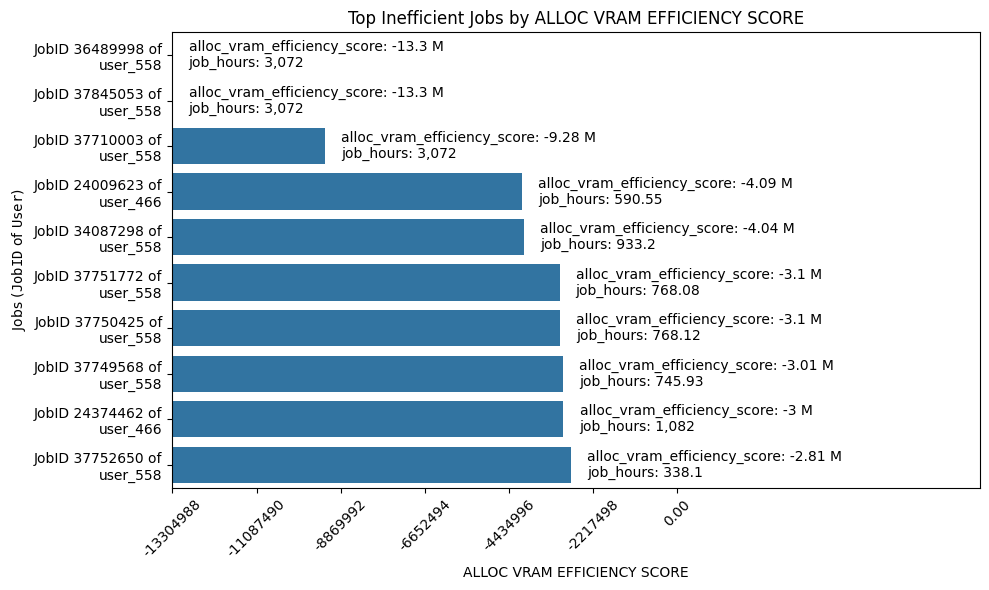

In [ ]:
low_alloc_vram_score_jobs = no_vram_constraint_efficiency_analysis.sort_and_filter_records_with_metrics(
    metrics_df_name_enum=MetricsDataFrameNameEnum.JOBS,
    sorting_key="alloc_vram_efficiency_score",
    ascending=True,  # Sort by alloc_vram_efficiency_score in ascending order
    filter_criteria={
        "alloc_vram_efficiency_score": {"max": -10, "inclusive": True},  # score threshold
    },
)
# Display top inefficient users by alloc_vram_efficiency_score
print("\nTop inefficient Jobs by allocated VRAM efficiency score:")

display(low_alloc_vram_score_jobs.head(5))

jobs_with_metrics_visualizer = JobsWithMetricsVisualizer(low_alloc_vram_score_jobs.head(10))
jobs_with_metrics_visualizer.visualize(
    column="alloc_vram_efficiency_score",
    bar_label_columns=["alloc_vram_efficiency_score", "job_hours"],
    figsize=(10, 6),
)